# Qiskit VQE tutorial
Following https://learning.quantum.ibm.com/tutorial/variational-quantum-eigensolver#isa-observable 

In [1]:
# General imports
import numpy as np

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

In [2]:
# runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator

# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum", token="d7b55bcdcf222ad6aa9d85d01405645658facca7ed1cd3b304eabe6ded9bc5d90a5e4b783431c844e7a606e5206d1adbd0246b29c4d71392ae14b8b4d94e9e18")
backend = service.least_busy(operational=True, simulator=False)

In [3]:
from utils import *

In [4]:
hamiltonian = xxz_hamiltonian(3, 0.5)

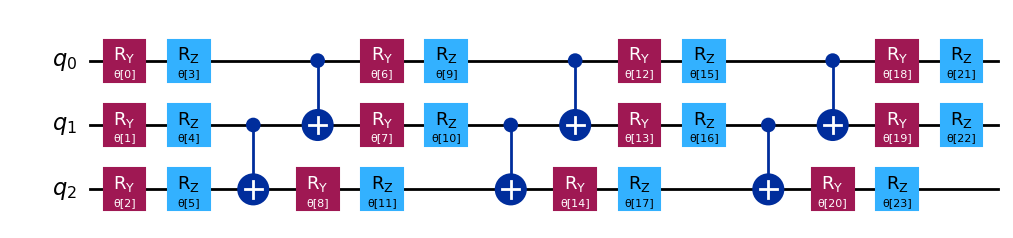

In [5]:
# VQE circuit
ansatz = EfficientSU2(hamiltonian.num_qubits)
ansatz.decompose().draw("mpl", style="iqp")

In [6]:
# vector param:
num_params = ansatz.num_parameters
num_params

24

## Optimize circuit for quantum execution

Schedule a series of 
qiskit.transpiler
 passes to optimize the circuit for a selected backend and make it compatible with the backend's ISA.

In [7]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)

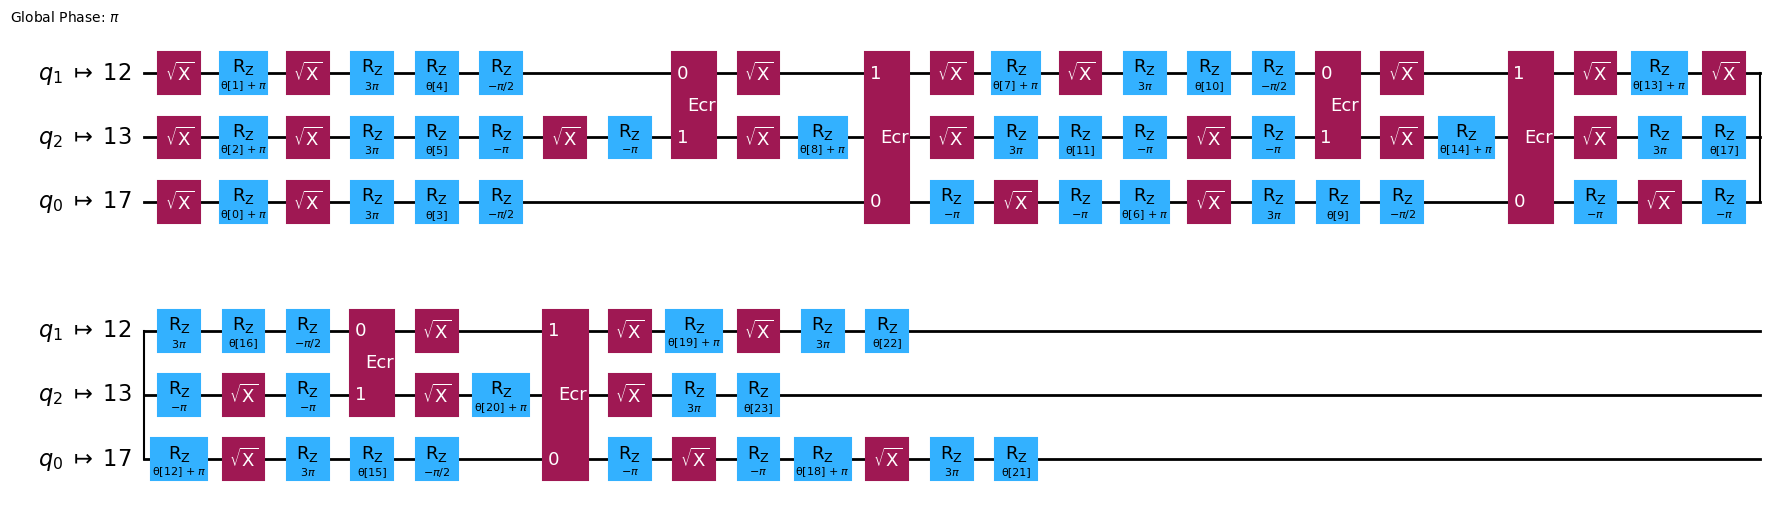

In [8]:
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [9]:
# transform hamiltonian to be backend-compatible
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

## Cost function

In [10]:
def cost_func(params, ansatz, hamiltonian, estimator, cost_history_dict):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

In [11]:
# initialize cost_history_dict
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

In [12]:
# random initialization of params
x0 = 2 * np.pi * np.random.random(num_params)

: 

In [13]:
# submit large number of jobs together using `Session`
with Session(backend=backend) as session:
    estimator = Estimator(session=session)
    estimator.options.default_shots = 10000

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator, cost_history_dict),
        method="cobyla",
    )

/var/folders/sn/4ym_qb8x0cs_f961d78kvvkc0000gn/T/ipykernel_87280/1752435977.py:3: DeprecationWarning: The 'session' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  estimator = Estimator(session=session)


Iters. done: 1 [Current cost: 1.131378246654756]
Iters. done: 2 [Current cost: 1.2718591742264234]
Iters. done: 3 [Current cost: 0.867459085024016]
Iters. done: 4 [Current cost: 1.6356707530787842]
Iters. done: 5 [Current cost: 0.6113904599876195]
Iters. done: 6 [Current cost: 0.5653604572819542]
Iters. done: 7 [Current cost: 0.36849463079059935]
Iters. done: 8 [Current cost: 0.5108557666263092]
Iters. done: 9 [Current cost: 0.2914541291653294]
Iters. done: 10 [Current cost: 0.7121776669651225]
Iters. done: 11 [Current cost: 0.38992954117180223]
Iters. done: 12 [Current cost: 0.9833450771553311]
Iters. done: 13 [Current cost: -1.0471486593768127]
Iters. done: 14 [Current cost: -1.304510038801155]


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.
Fatal Python error: F2PySwapThreadLocalCallbackPtr: F2PySwapThreadLocalCallbackPtr: PyLong_AsVoidPtr failed
Python runtime state: initialized
Traceback (most recent call last):
  File "/Users/pethidine/anaconda3/envs/ionq/lib/python3.12/site-packages/scipy/optimize/_cobyla_py.py", line 281, in calcfc
    f = sf.fun(x)
        ^^^^^^^^^
  File "/Users/pethidine/anaconda3/envs/ionq/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py", line 325, in fun
    self._update_fun()
  File "/Users/pethidine/anaconda3/envs/ionq/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py", line 294, in _update_fun
    fx = self._wrapped_fun(self.x)
         ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/pethidine/anaconda3/envs/ionq/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py", line 20, in wrapped
    fx = fun(np.copy(x), *args)
         ^^^^^^^^^^^^^^^^^^^^^^
  File "